In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.

In [2]:
import os
import cv2
import numpy as np
import shutil
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
import os

def convert_polygons_to_yolo_bbox_safe(label_dir, new_label_dir):
    os.makedirs(new_label_dir, exist_ok=True)
    
    for filename in os.listdir(label_dir):
        if filename.endswith(".txt"):
            filepath = os.path.join(label_dir, filename)
            new_filepath = os.path.join(new_label_dir, filename)
            
            new_lines = []
            with open(filepath, "r") as f:
                lines = f.read().strip().split("\n")
                
            for line in lines:
                parts = line.strip().split()
                if len(parts) > 1:
                    class_id = parts[0]
                    coords = list(map(float, parts[1:]))
                    if len(coords) % 2 == 0:
                        xs = coords[::2]
                        ys = coords[1::2]
                        min_x, max_x = min(xs), max(xs)
                        min_y, max_y = min(ys), max(ys)
                        x_center = (min_x + max_x) / 2
                        y_center = (min_y + max_y) / 2
                        width = max_x - min_x
                        height = max_y - min_y
                        new_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
                        new_lines.append(new_line)
            
            # Write new file
            with open(new_filepath, "w") as f:
                f.write("\n".join(new_lines))

# Example:
convert_polygons_to_yolo_bbox_safe(
    '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels',
    '/kaggle/working/train/labels')
convert_polygons_to_yolo_bbox_safe(
    '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels',
    '/kaggle/working/valid/labels')
convert_polygons_to_yolo_bbox_safe(
    '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/labels',
    '/kaggle/working/test/labels')

In [4]:
def copy_images(src_image_dir, dst_image_dir):
    os.makedirs(dst_image_dir, exist_ok=True)
    for filename in os.listdir(src_image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            shutil.copy2(os.path.join(src_image_dir, filename),
                         os.path.join(dst_image_dir, filename))

copy_images('/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images',
            '/kaggle/working/train/images')

copy_images('/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images',
            '/kaggle/working/valid/images')

copy_images('/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images',
            '/kaggle/working/test/images')

In [5]:
yaml_content = """
train: /kaggle/working/train/images
val: /kaggle/working/valid/images
test: /kaggle/working/test/images

nc: 6
names: ['elbow positive', 'fingers positive', 'forearm fracture',
        'humerus fracture', 'shoulder fracture', 'wrist positive']
"""

with open('/kaggle/working/bonefracture.yaml', 'w') as f:
    f.write(yaml_content.strip())

In [6]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
model.train(data='/kaggle/working/bonefracture.yaml', epochs=20, imgsz=225)

100%|██████████| 6.25M/6.25M [00:00<00:00, 72.0MB/s]


Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/bonefracture.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=225, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

100%|██████████| 755k/755k [00:00<00:00, 41.4MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 152MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[225] must be multiple of max stride 32, updating to [256]
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 369.3±166.1 MB/s, size: 12.1 KB)


train: Scanning /kaggle/working/train/labels... 3631 images, 1827 backgrounds, 168 corrupt: 100%|██████████| 3631/3631 [00:02<00:00, 1631.76it/s]

train: /kaggle/working/train/images/image1_1002_png.rf.1feafce607366113c97124dc22d52328.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
train: /kaggle/working/train/images/image1_1002_png.rf.67c46c90c7089ef2ffa40b5fa22e4ad1.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
train: /kaggle/working/train/images/image1_1002_png.rf.c94d11a79032d6beb4ce4d876c9f7fda.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
train: /kaggle/working/train/images/image1_1022_png.rf.077dcb969ab7f549f7bc09bddca07895.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
train: /kaggle/working/train/images/image1_1022_png.rf.8bb506fab5d76213a035adf3069a821c.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
train: /ka

train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 273.5±149.5 MB/s, size: 9.2 KB)


val: Scanning /kaggle/working/valid/labels... 348 images, 175 backgrounds, 17 corrupt: 100%|██████████| 348/348 [00:00<00:00, 1646.52it/s]

val: /kaggle/working/valid/images/image1_1090_png.rf.de645f822a5e36175c5e988223f4eeb0.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: /kaggle/working/valid/images/image1_111_png.rf.3893d8f7588cea4d796d26119e52637f.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: /kaggle/working/valid/images/image1_119_png.rf.77de12cb566fc295603927e2a5b2748a.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: /kaggle/working/valid/images/image1_1310_png.rf.daf759fe071a5733142e9847fb388e75.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: /kaggle/working/valid/images/image1_1802_png.rf.ada9b0ad89e89af07a36ed5590773b7e.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: /kaggle/working/v

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      0.42G      3.392      5.161      2.056          4        256: 100%|██████████| 217/217 [00:19<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]

                   all        331        176      0.604     0.0667    0.00543     0.0011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.479G      3.003      4.149      1.738          5        256: 100%|██████████| 217/217 [00:17<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.06it/s]

                   all        331        176     0.0389      0.134     0.0269    0.00627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.496G      2.897      3.721      1.723          4        256: 100%|██████████| 217/217 [00:16<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.56it/s]

                   all        331        176     0.0643       0.09     0.0401     0.0147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.514G      2.847        3.5      1.678          7        256: 100%|██████████| 217/217 [00:16<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.42it/s]

                   all        331        176      0.852     0.0389     0.0473     0.0177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.531G      2.812      3.232      1.665          2        256: 100%|██████████| 217/217 [00:16<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.95it/s]

                   all        331        176      0.272      0.128     0.0667       0.02



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.547G        2.7      3.108      1.605          5        256: 100%|██████████| 217/217 [00:16<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.08it/s]


                   all        331        176       0.13       0.13     0.0909     0.0286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.564G      2.622      2.989      1.559          3        256: 100%|██████████| 217/217 [00:16<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.05it/s]


                   all        331        176      0.154      0.164      0.122      0.046

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.582G      2.581      2.833       1.54          4        256: 100%|██████████| 217/217 [00:16<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.09it/s]

                   all        331        176      0.522      0.129       0.15     0.0548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       0.6G      2.538      2.778      1.522          5        256: 100%|██████████| 217/217 [00:16<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.66it/s]

                   all        331        176      0.194      0.211      0.152     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.615G      2.519      2.735      1.494          7        256: 100%|██████████| 217/217 [00:16<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.64it/s]

                   all        331        176      0.218      0.195      0.171     0.0616


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.631G      2.452        2.7      1.556          4        256: 100%|██████████| 217/217 [00:16<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.48it/s]

                   all        331        176      0.265      0.269      0.221     0.0773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.648G        2.4      2.512      1.545         10        256: 100%|██████████| 217/217 [00:16<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.13it/s]

                   all        331        176      0.282      0.209      0.183     0.0675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.666G      2.331      2.397      1.525          5        256: 100%|██████████| 217/217 [00:15<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.80it/s]

                   all        331        176      0.245      0.235      0.193     0.0685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.682G      2.291      2.287       1.51          6        256: 100%|██████████| 217/217 [00:16<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.69it/s]

                   all        331        176      0.278      0.254      0.209      0.075



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.699G      2.224      2.159      1.471          3        256: 100%|██████████| 217/217 [00:15<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.70it/s]

                   all        331        176      0.292      0.277      0.261     0.0989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.717G      2.203      2.083      1.452          4        256: 100%|██████████| 217/217 [00:16<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.68it/s]

                   all        331        176      0.357       0.27      0.241     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.734G       2.16      1.995      1.426          1        256: 100%|██████████| 217/217 [00:15<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  8.93it/s]


                   all        331        176      0.327      0.254      0.246     0.0902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      0.75G       2.11      1.935      1.407          4        256: 100%|██████████| 217/217 [00:16<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.71it/s]

                   all        331        176       0.39      0.251      0.265        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20     0.768G       2.07      1.861      1.388          4        256: 100%|██████████| 217/217 [00:16<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.02it/s]

                   all        331        176      0.406      0.277       0.28      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20     0.785G      2.006      1.814      1.352          7        256: 100%|██████████| 217/217 [00:15<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.01it/s]

                   all        331        176      0.378      0.238      0.266      0.103



20 epochs completed in 0.100 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.43it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        331        176       0.35      0.239      0.266      0.103
        elbow positive         28         29      0.165      0.069     0.0633     0.0261
      fingers positive         41         48        0.2      0.104      0.157     0.0547
      forearm fracture         37         43      0.558      0.395      0.422      0.146
     shoulder fracture         31         36      0.623      0.472      0.518      0.249
        wrist positive         19         20      0.204      0.154       0.17     0.0392
Speed: 0.0ms preprocess, 0.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f97394a5050>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [7]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')  # replace with your path

metrics = model.val()

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 418.5±191.0 MB/s, size: 10.4 KB)


val: Scanning /kaggle/working/valid/labels.cache... 348 images, 175 backgrounds, 17 corrupt: 100%|██████████| 348/348 [00:00<?, ?it/s]

val: /kaggle/working/valid/images/image1_1090_png.rf.de645f822a5e36175c5e988223f4eeb0.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: /kaggle/working/valid/images/image1_111_png.rf.3893d8f7588cea4d796d26119e52637f.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: /kaggle/working/valid/images/image1_119_png.rf.77de12cb566fc295603927e2a5b2748a.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: /kaggle/working/valid/images/image1_1310_png.rf.daf759fe071a5733142e9847fb388e75.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: /kaggle/working/valid/images/image1_1802_png.rf.ada9b0ad89e89af07a36ed5590773b7e.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: /kaggle/working/v


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:01<00:00, 11.66it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        331        176      0.376      0.242      0.265      0.103
        elbow positive         28         29      0.194      0.069     0.0649     0.0264
      fingers positive         41         48       0.21      0.104       0.15     0.0521
      forearm fracture         37         43       0.61      0.395      0.426      0.151
     shoulder fracture         31         36      0.631      0.472       0.52      0.249
        wrist positive         19         20      0.233      0.168      0.162     0.0372
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val


In [8]:
print(metrics.box.map)       # mAP@0.5
print(metrics.box.map50)     # same as map
print(metrics.box.map75)     # mAP@0.75

0.10317931278589366
0.26451083333136877
0.05805263768154238


In [9]:
# Per-class AP values
per_class_ap = metrics.box.maps  # list of floats

for idx, ap in enumerate(per_class_ap):
    print(f"Class {idx}: AP={ap:.3f}")

Class 0: AP=0.026
Class 1: AP=0.052
Class 2: AP=0.151
Class 3: AP=0.103
Class 4: AP=0.249
Class 5: AP=0.037


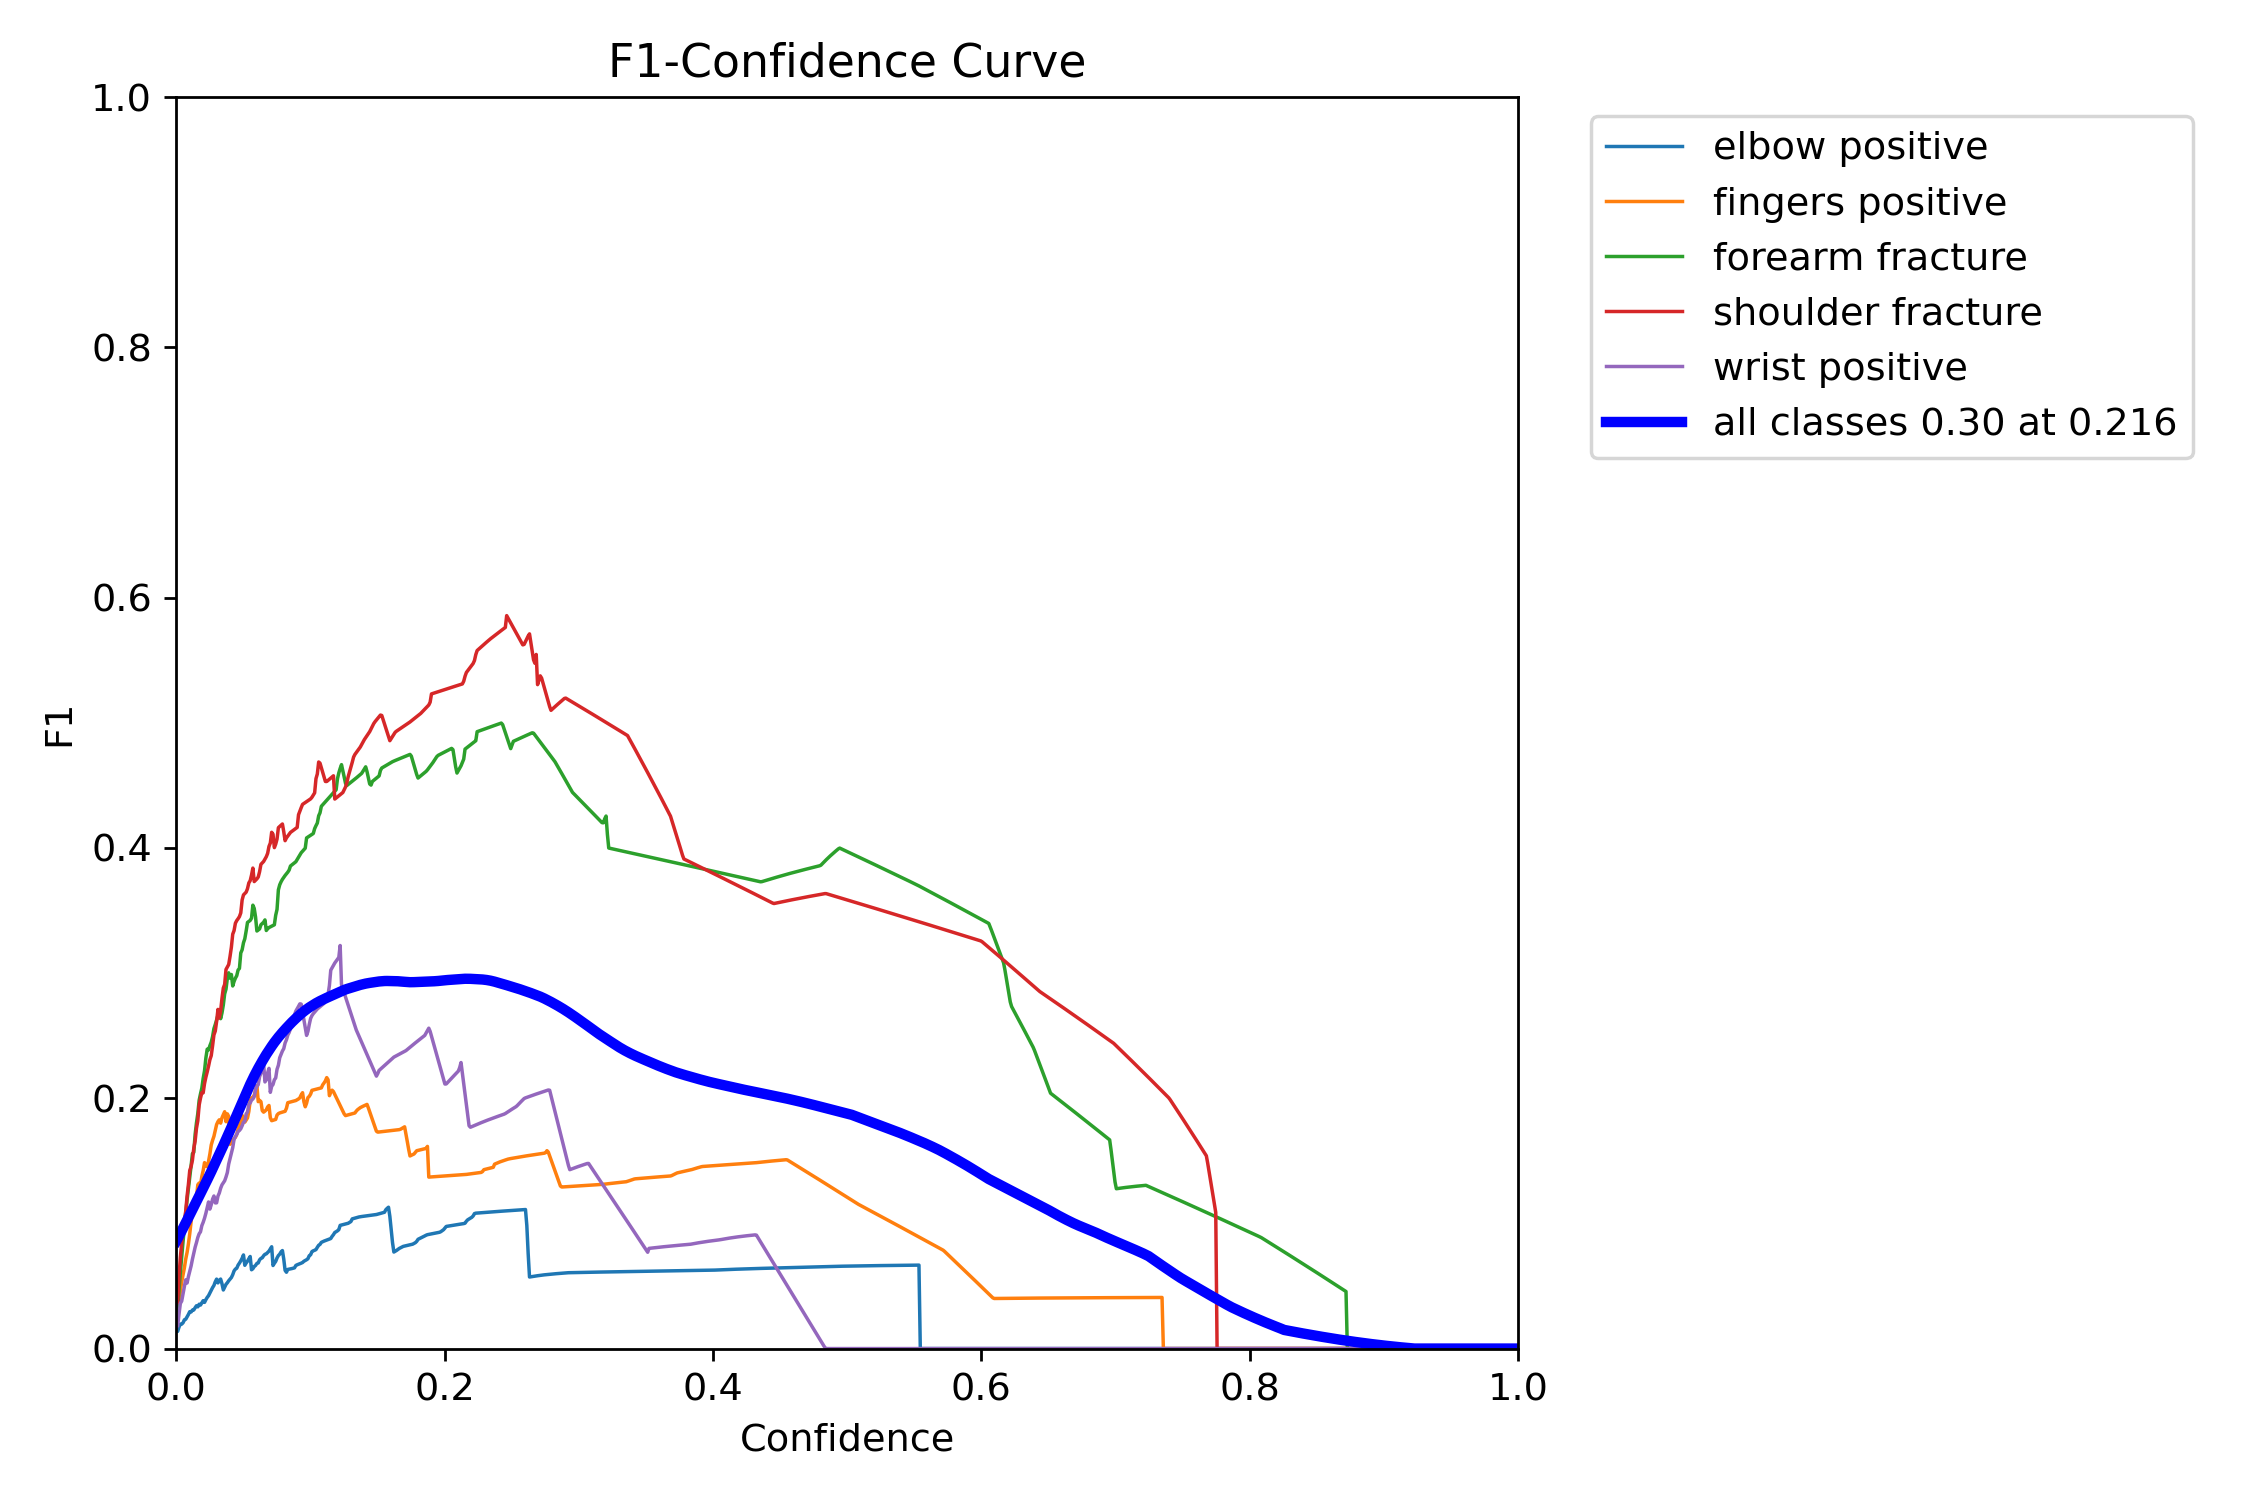

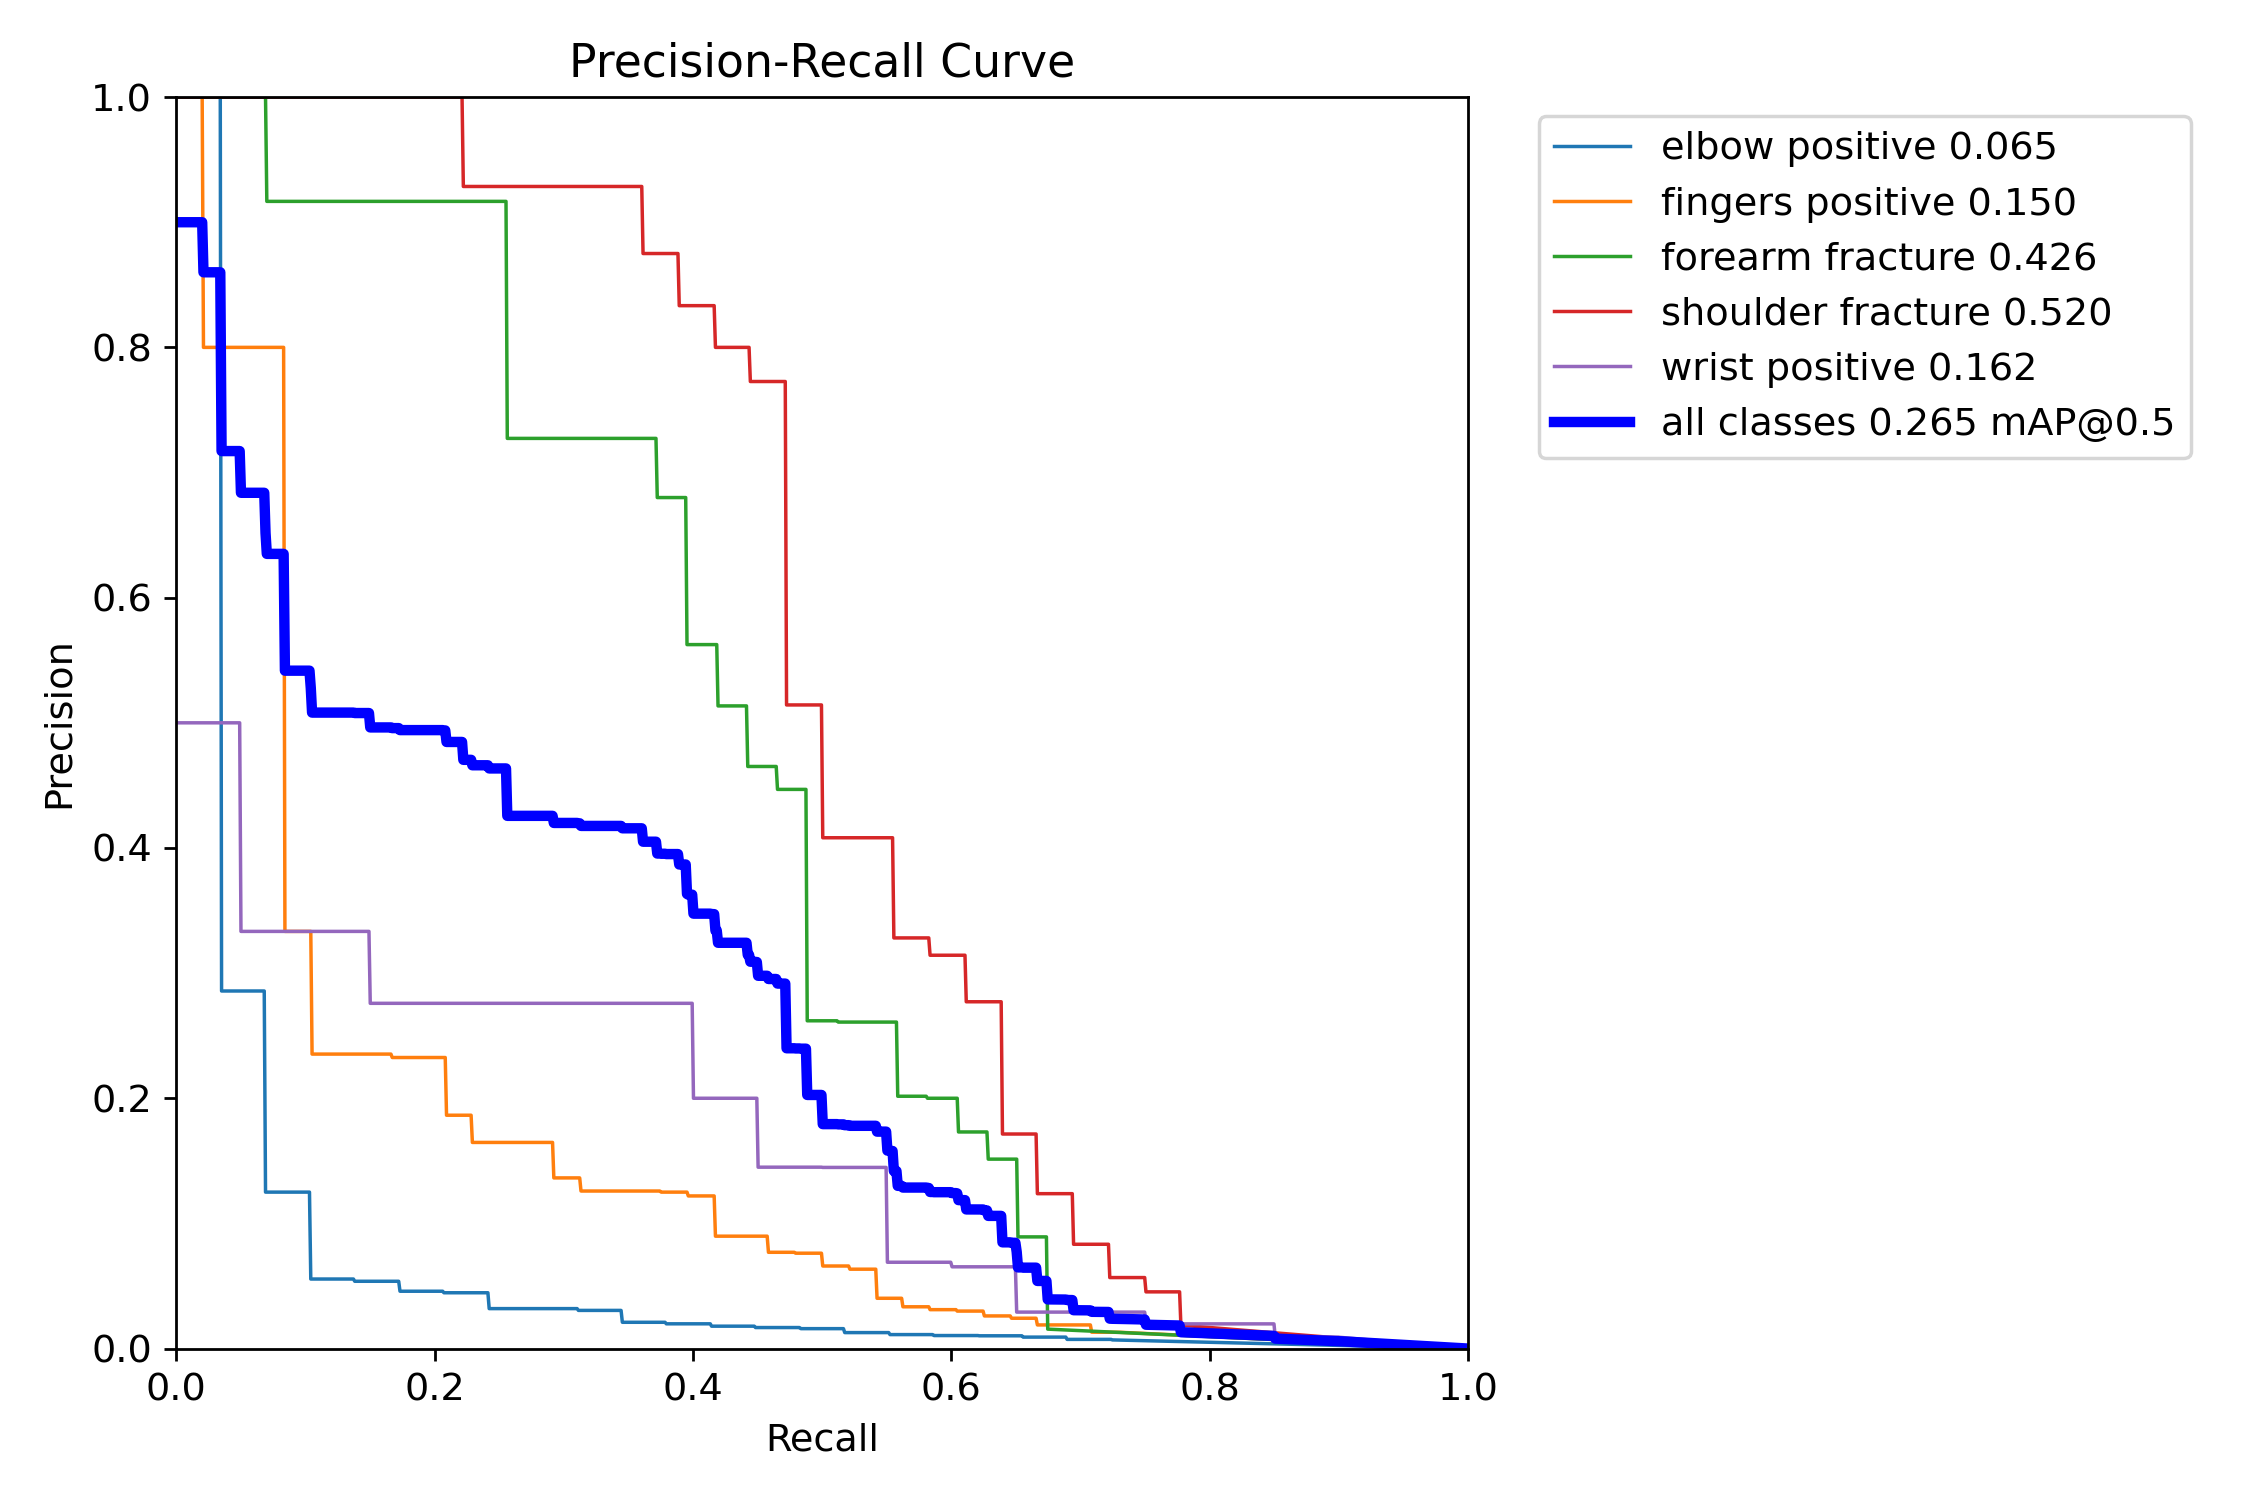

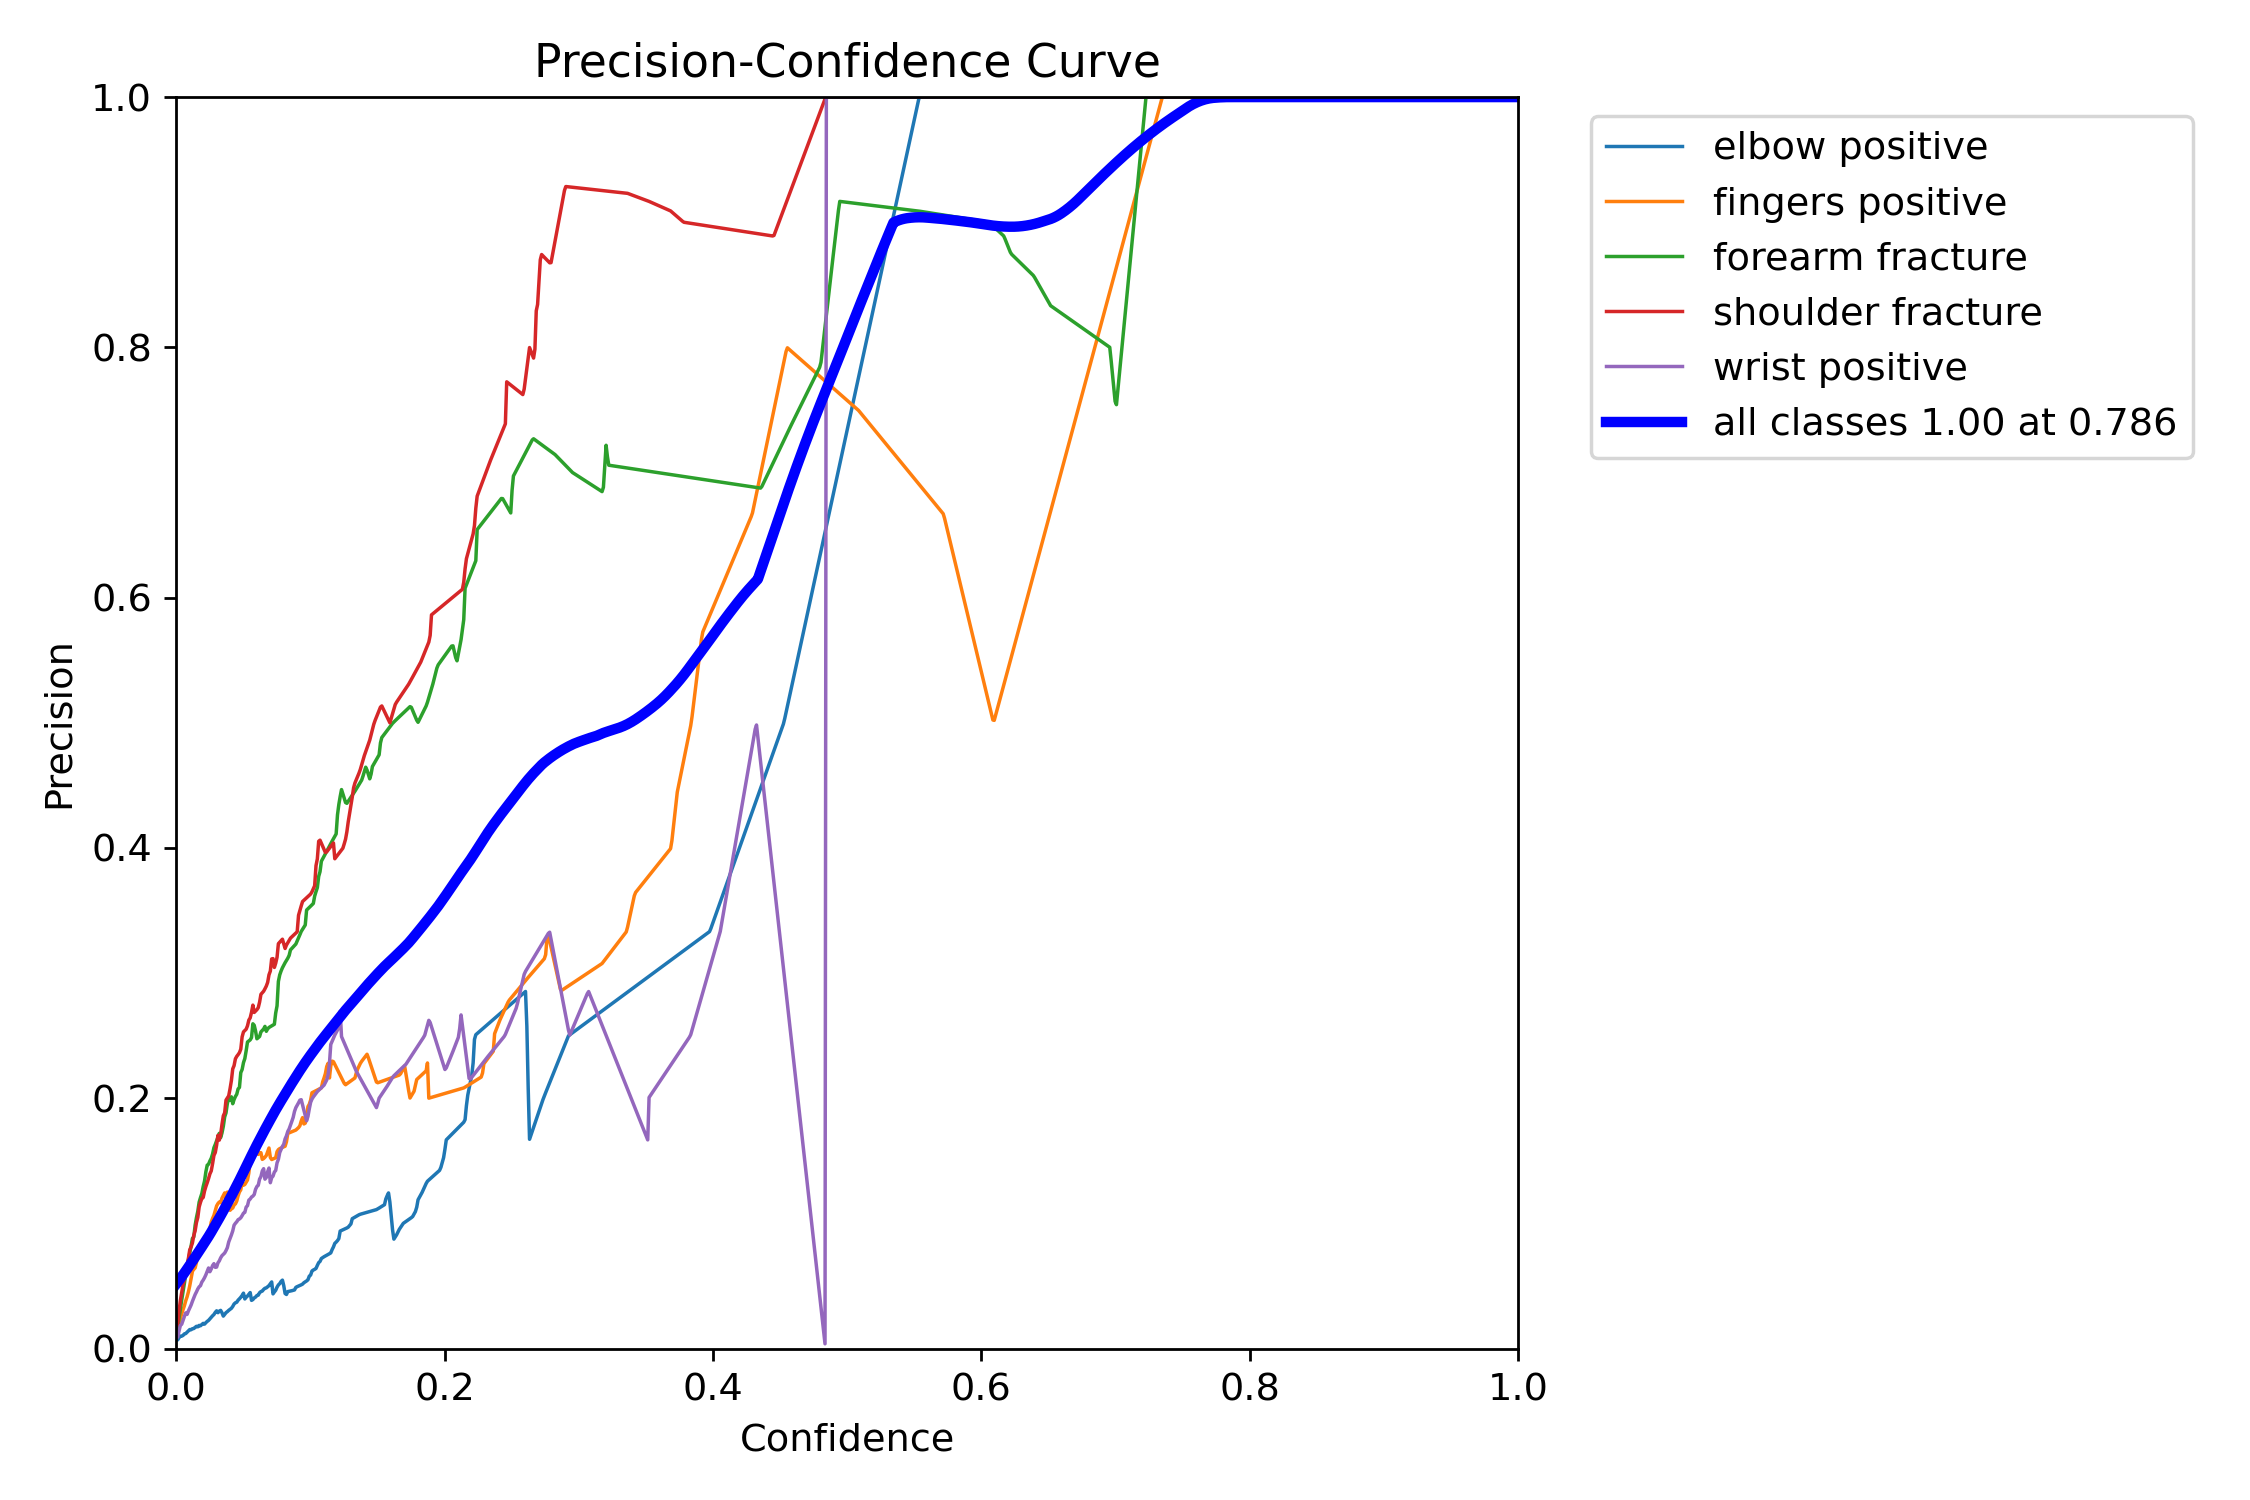

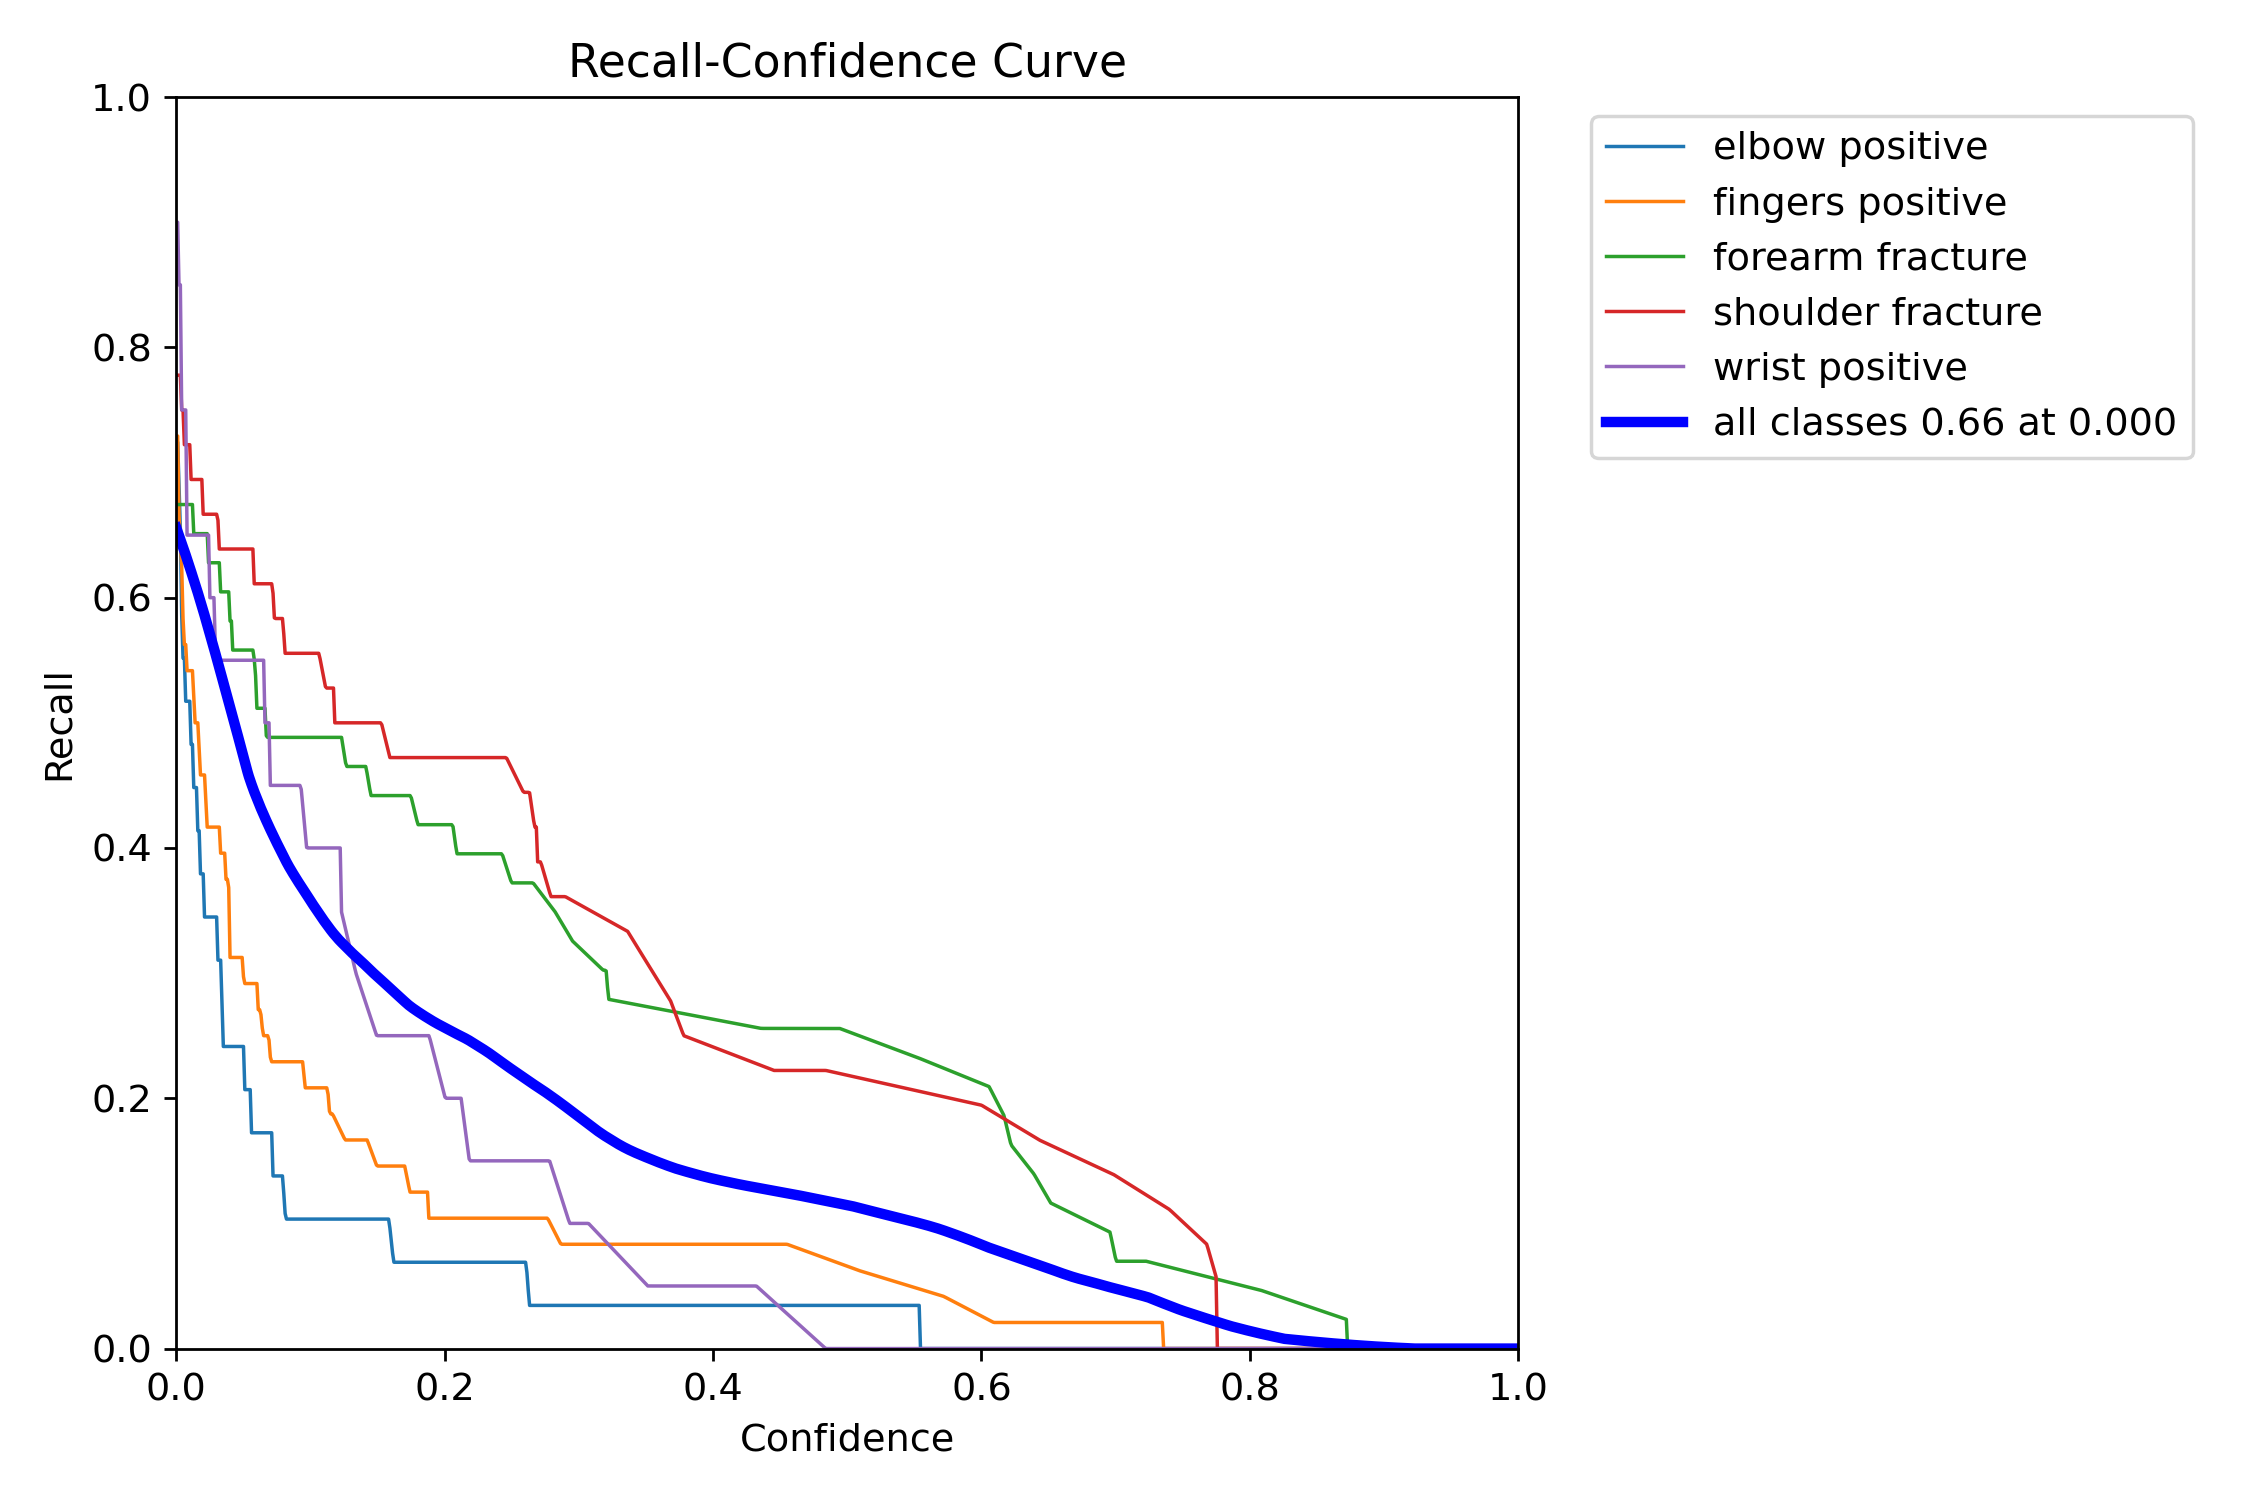

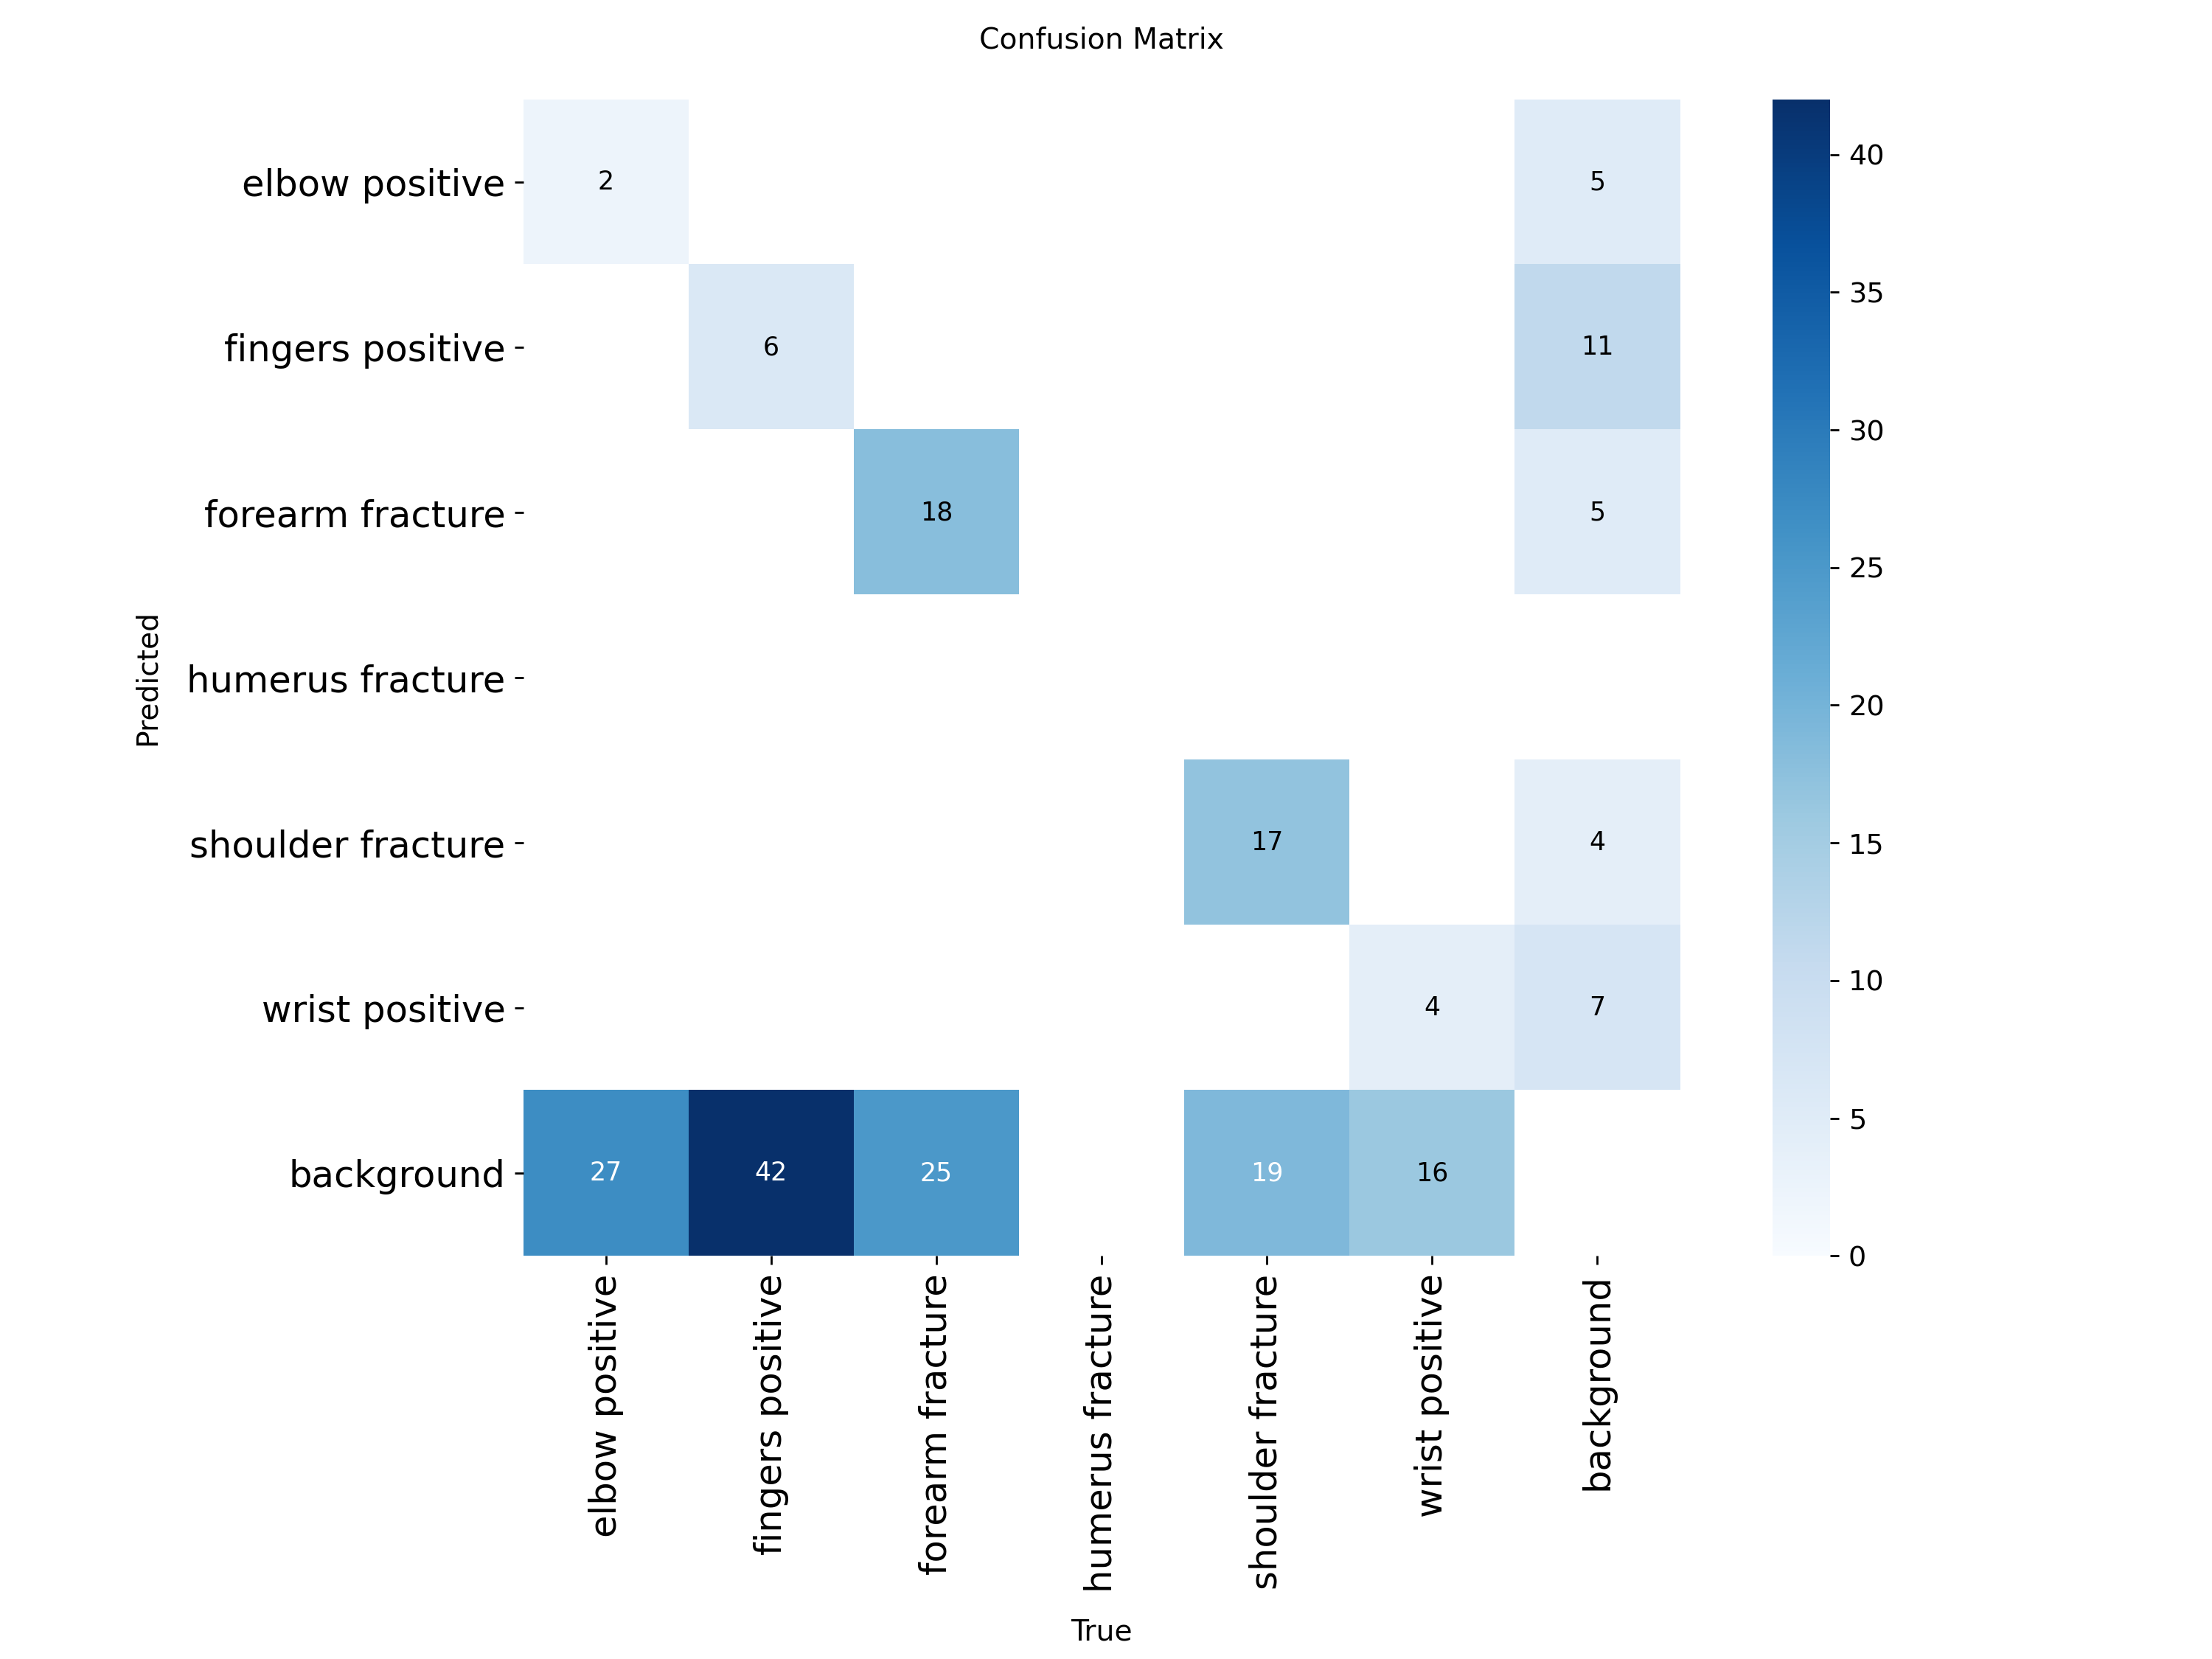

In [10]:
from IPython.display import Image, display

display(Image('/kaggle/working/runs/detect/val/F1_curve.png'))
display(Image('/kaggle/working/runs/detect/val/PR_curve.png'))
display(Image('/kaggle/working/runs/detect/val/P_curve.png'))
display(Image('/kaggle/working/runs/detect/val/R_curve.png'))
display(Image('/kaggle/working/runs/detect/val/confusion_matrix.png'))

Desired Predictions


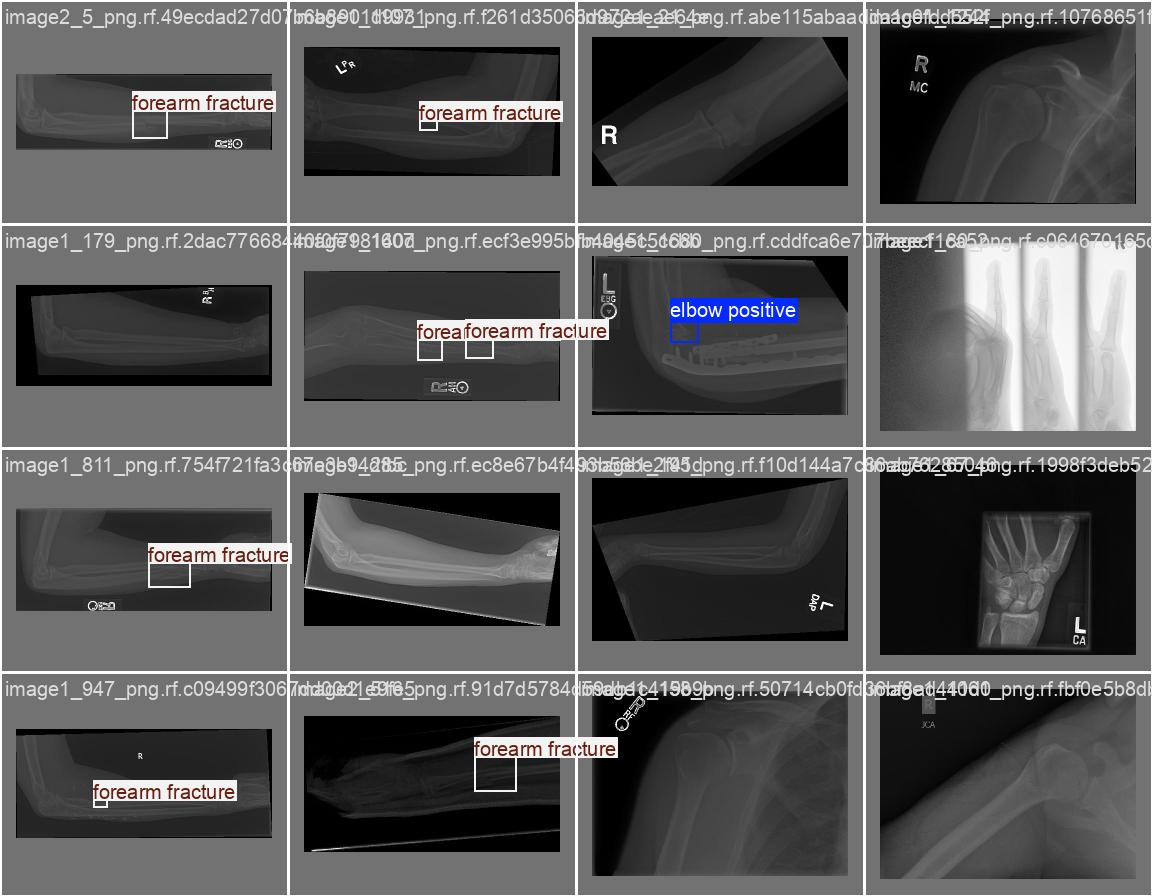

Actual Predictions


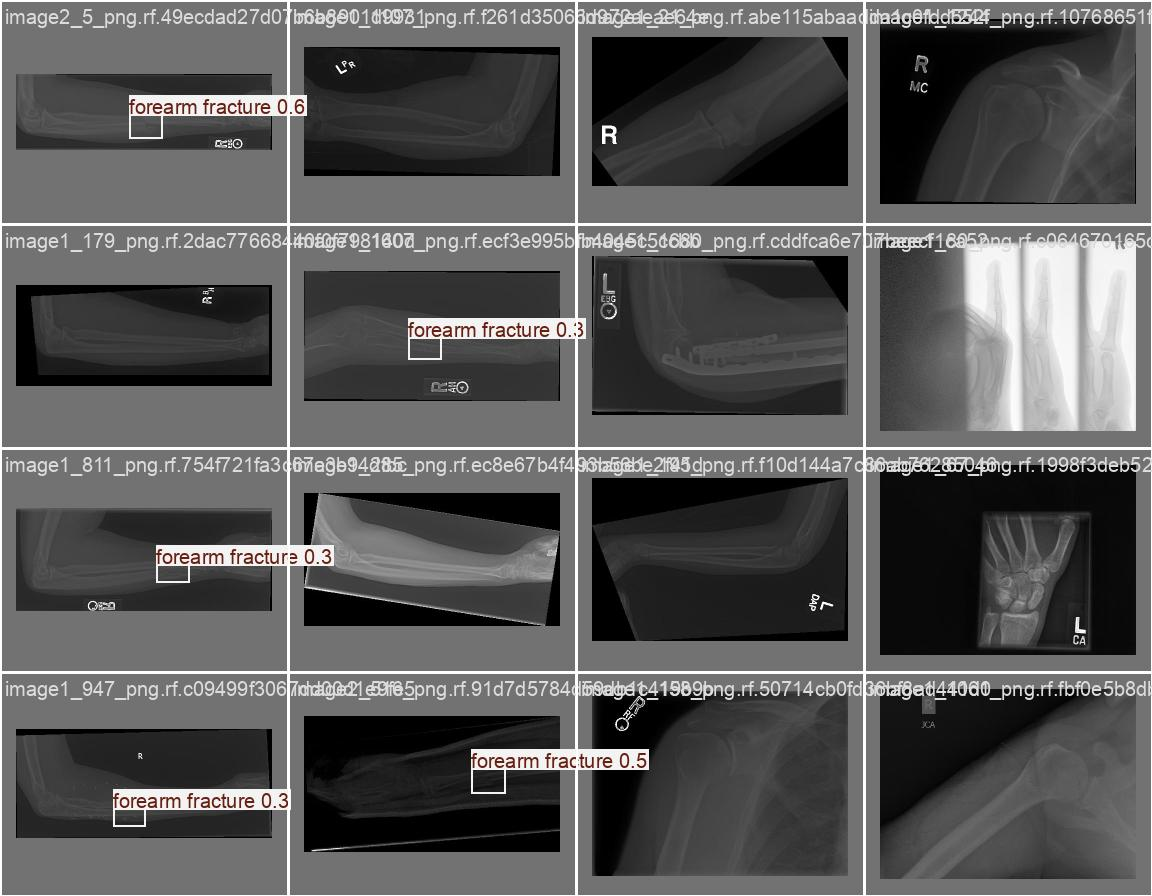

In [11]:
print('Desired Predictions')
display(Image('/kaggle/working/runs/detect/val/val_batch0_labels.jpg'))
print('Actual Predictions')
display(Image('/kaggle/working/runs/detect/val/val_batch0_pred.jpg'))